In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install xgboost
!pip install imbalanced-learn

# Import library

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [87]:
data = pd.read_csv('/content/drive/MyDrive/DSS/Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [88]:
data.shape

(10000, 14)

# EDA

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [90]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [91]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [92]:
# Correlation
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-92-7d0bed9fa271>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()
<ipython-input-92-7d0bed9fa271>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.00,0.00,0.01,0.00,-0.01,-0.01,0.01,0.00,0.01,-0.01,-0.02
CustomerId,0.00,1.00,0.01,0.01,-0.01,-0.01,0.02,-0.01,0.00,0.02,-0.01
CreditScore,0.01,0.01,1.00,-0.00,0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
Age,0.00,0.01,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
Tenure,-0.01,-0.01,0.00,-0.01,1.00,-0.01,0.01,0.02,-0.03,0.01,-0.01
Balance,-0.01,-0.01,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
NumOfProducts,0.01,0.02,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
HasCrCard,0.00,-0.01,-0.01,-0.01,0.02,-0.01,0.00,1.00,-0.01,-0.01,-0.01
IsActiveMember,0.01,0.00,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
EstimatedSalary,-0.01,0.02,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01


In [93]:
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

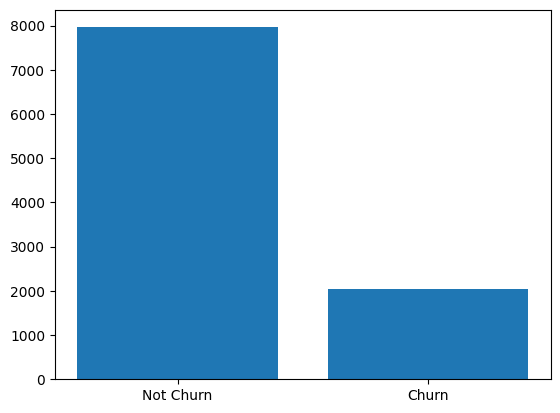

In [94]:
labels = ['Not Churn', 'Churn']
values = data['Exited'].value_counts()

plt.bar(labels, values)
plt.show()

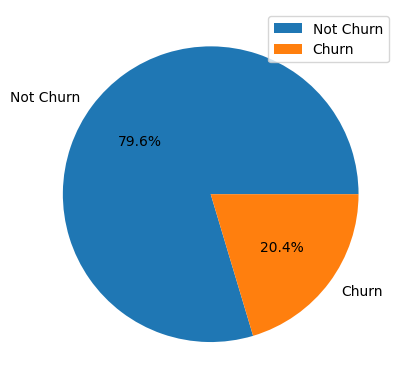

In [100]:
labels = ['Not Churn', 'Churn']
values = data['Exited'].value_counts()

plt.pie(values, labels = labels, autopct='%1.1f%%')
plt.legend()
plt.show()

In [41]:
object_cols = [f for f in data.columns if data[f].dtype =="O"]
print(object_cols)

['Surname', 'Geography', 'Gender']


In [42]:
numeric_cols = [f for f in data.columns if data[f].dtype !="O"]
print(numeric_cols)

['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


IndexError: ignored

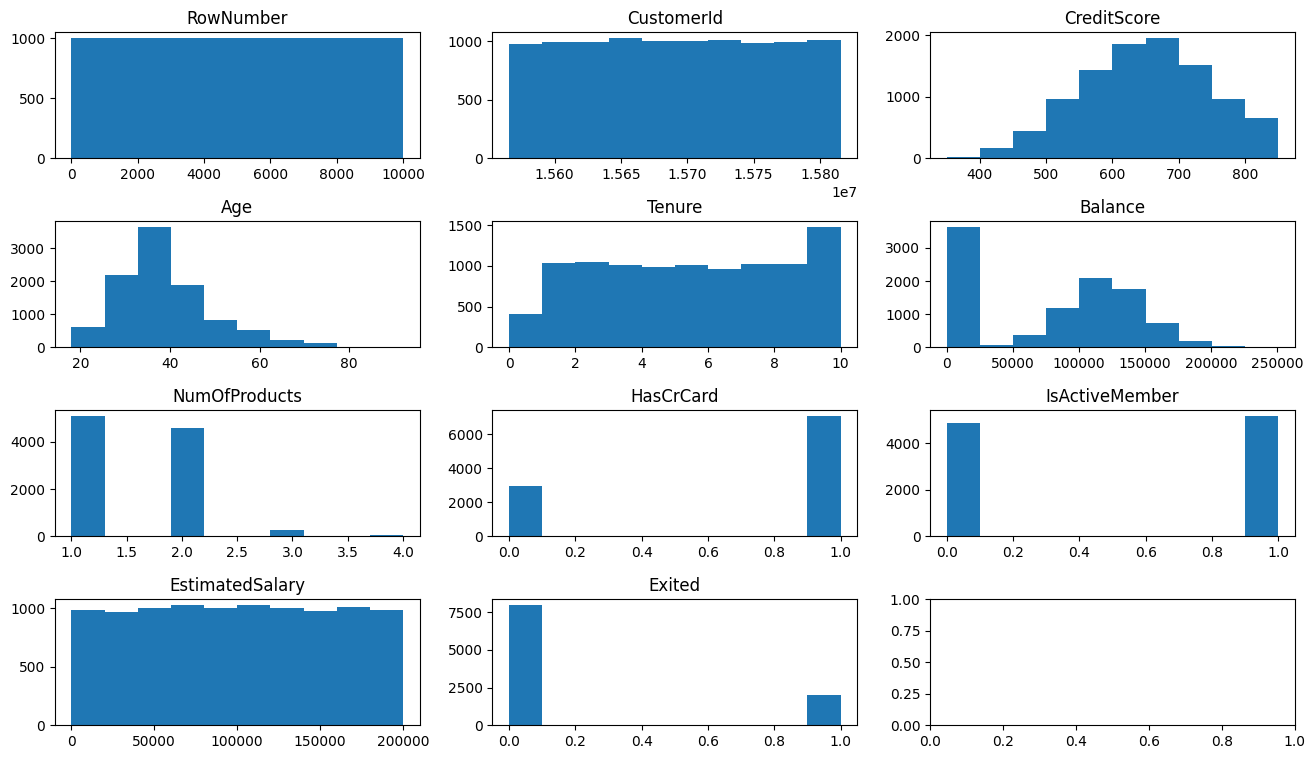

In [79]:
fig, ax = plt.subplots(4, 3, figsize = (16, 9))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
for i, ax in enumerate(ax.flat):
  ax.hist(data[numeric_cols[i]])
  ax.set_title(numeric_cols[i])
plt.show()

# Data processing

In [15]:
# Remove col not contribute for model
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [16]:
# one hot enconding category col
data = pd.get_dummies(data,drop_first = True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [18]:
# scaling
scale_cols = ['CreditScore', 'Age',	'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = MinMaxScaler()
data[scale_cols] = scaler.fit_transform(data[scale_cols])
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,0,0,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,0,0,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,0,0,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,1,0


In [19]:
X = data.drop(['Exited'], axis = 1)
y = data['Exited']

# Model

1.   Ko upsampling, ko scale. Model: XGBOOST, Random Forest, Gradient Boosting
2.   Ko upsampling, scale. Model: Logistic, XGBOOST,
Random Forest, Gradient Boosting
1.   Up sampling bằng SMOTE, ko scale. Model: XGBOOST, Random Forest, Gradient Boosting
2.   Up sampling, Scale: Logistic, XGBOOST, Random Forest, Gradient Boosting

## Upsampling, Scale



In [20]:
# Upsamping
sm = SMOTE()
X_train_resample, y_train_resample = sm.fit_resample(X, y)
print(X_train_resample.shape, y_train_resample.shape)

(15926, 11) (15926,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_train_resample, y_train_resample, test_size = 0.2, random_state=42)

In [22]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier(n_estimators=200, random_state=42)
model_RFC.fit(X_train, y_train)
y_pred = model_RFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1633
           1       0.89      0.91      0.90      1553

    accuracy                           0.90      3186
   macro avg       0.90      0.90      0.90      3186
weighted avg       0.90      0.90      0.90      3186

